In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import itertools
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed
import tqdm

In [3]:
df = pd.read_csv('DF_FINAL.csv')
df

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id
0,A,a,AC,TP 0.2,2023-01-06,1.000000,0.010000,A_a_AC_TP 0.2
1,A,a,AC,TP 0.2,2023-01-13,1.000000,4.010000,A_a_AC_TP 0.2
2,A,a,AC,TP 0.2,2023-01-20,61.000000,6.010000,A_a_AC_TP 0.2
3,A,a,AC,TP 0.2,2023-01-27,0.000000,8.010000,A_a_AC_TP 0.2
4,A,a,AC,TP 0.2,2023-02-03,18.879000,9.520000,A_a_AC_TP 0.2
...,...,...,...,...,...,...,...,...
58305,I,an,AD,PET 1.0,2024-11-29,54.766687,78.192999,I_an_AD_PET 1.0
58306,I,an,AD,PET 1.0,2024-12-06,65.133425,171.193998,I_an_AD_PET 1.0
58307,I,an,AD,PET 1.0,2024-12-13,59.458602,46.503001,I_an_AD_PET 1.0
58308,I,an,AD,PET 1.0,2024-12-20,77.697035,8.463000,I_an_AD_PET 1.0


In [4]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])
df

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id
0,A,a,AC,TP 0.2,2023-01-06,1.000000,0.010000,A_a_AC_TP 0.2
1,A,a,AC,TP 0.2,2023-01-13,1.000000,4.010000,A_a_AC_TP 0.2
2,A,a,AC,TP 0.2,2023-01-20,61.000000,6.010000,A_a_AC_TP 0.2
3,A,a,AC,TP 0.2,2023-01-27,0.000000,8.010000,A_a_AC_TP 0.2
4,A,a,AC,TP 0.2,2023-02-03,18.879000,9.520000,A_a_AC_TP 0.2
...,...,...,...,...,...,...,...,...
58305,I,an,AD,PET 1.0,2024-11-29,54.766687,78.192999,I_an_AD_PET 1.0
58306,I,an,AD,PET 1.0,2024-12-06,65.133425,171.193998,I_an_AD_PET 1.0
58307,I,an,AD,PET 1.0,2024-12-13,59.458602,46.503001,I_an_AD_PET 1.0
58308,I,an,AD,PET 1.0,2024-12-20,77.697035,8.463000,I_an_AD_PET 1.0


In [29]:
# Выбор одного ряда по row_id
example_row_id = 'A_a_AD_PET 1.0'  # или укажи конкретно
df_one = df[df['row_id'] == example_row_id].copy()

df_one

,Territory_code,Plant_code,Brand_code,Package,Week_End_Date,Sum of Plan,fact,row_id
208,A,a,AD,PET 1.0,2023-01-06,254.000000,188.010000,A_a_AD_PET 1.0
209,A,a,AD,PET 1.0,2023-01-13,265.000000,266.010000,A_a_AD_PET 1.0
210,A,a,AD,PET 1.0,2023-01-20,1923.000000,557.010000,A_a_AD_PET 1.0
211,A,a,AD,PET 1.0,2023-01-27,1137.000000,1505.010000,A_a_AD_PET 1.0
212,A,a,AD,PET 1.0,2023-02-03,129.066998,357.155996,A_a_AD_PET 1.0
...,...,...,...,...,...,...,...,...
307,A,a,AD,PET 1.0,2024-11-29,89.252734,103.561001,A_a_AD_PET 1.0
308,A,a,AD,PET 1.0,2024-12-06,0.000000,0.010000,A_a_AD_PET 1.0
309,A,a,AD,PET 1.0,2024-12-13,112.752272,169.080002,A_a_AD_PET 1.0
310,A,a,AD,PET 1.0,2024-12-20,95.839429,164.851998,A_a_AD_PET 1.0


In [30]:
# Временной ряд
series = df_one['fact']

# Размеры
n_total = len(series)
n_train = int(n_total * 0.90)
n_val = int(n_total * 0.05)

# Деление
train = series.iloc[:n_train]
val = series.iloc[n_train:n_train + n_val]
test = series.iloc[n_train + n_val:]

# Проверка
print(f"Всего точек: {n_total}")
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Всего точек: 104
Train: 93, Val: 5, Test: 6


In [31]:
# Сетка параметров (можно расширить)
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)

In [32]:
best_score, best_cfg = float("inf"), None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Прогноз на валидацию
        forecast = model_fit.forecast(steps=len(val))
        mae = mean_absolute_error(val, forecast)
        
        print(f"ARIMA({p},{d},{q}) MAE = {mae:.4f}")
        
        if mae < best_score:
            best_score, best_cfg = mae, (p, d, q)
    except:
        continue

print(f"\nЛучшие параметры: ARIMA{best_cfg} с MAE = {best_score:.4f}")

ARIMA(0,0,0) MAE = 138.6305
ARIMA(0,0,1) MAE = 141.3188
ARIMA(0,0,2) MAE = 140.2255
ARIMA(0,0,3) MAE = 141.6279
ARIMA(0,1,0) MAE = 166.9536
ARIMA(0,1,1) MAE = 26.1794
ARIMA(0,1,2) MAE = 140.6828
ARIMA(0,1,3) MAE = 139.4911
ARIMA(0,2,0) MAE = 864.3516
ARIMA(0,2,1) MAE = 171.0904
ARIMA(0,2,2) MAE = 54.4940
ARIMA(0,2,3) MAE = 193.9967
ARIMA(0,3,0) MAE = 3128.6136
ARIMA(0,3,1) MAE = 878.8763
ARIMA(0,3,2) MAE = 113.2622
ARIMA(0,3,3) MAE = 258.5636
ARIMA(1,0,0) MAE = 140.5497
ARIMA(1,0,1) MAE = 125.1802
ARIMA(1,0,2) MAE = 141.3585
ARIMA(1,0,3) MAE = 140.5199
ARIMA(1,1,0) MAE = 92.8690
ARIMA(1,1,1) MAE = 29.7234
ARIMA(1,1,2) MAE = 134.0305
ARIMA(1,1,3) MAE = 140.6982
ARIMA(1,2,0) MAE = 429.4460
ARIMA(1,2,1) MAE = 93.9360
ARIMA(1,2,2) MAE = 183.9976
ARIMA(1,2,3) MAE = 210.4432
ARIMA(1,3,0) MAE = 1621.0585
ARIMA(1,3,1) MAE = 431.7076
ARIMA(1,3,2) MAE = 83.1029
ARIMA(1,3,3) MAE = 154.2137
ARIMA(2,0,0) MAE = 135.7277
ARIMA(2,0,1) MAE = 121.4673
ARIMA(2,0,2) MAE = 138.7593
ARIMA(2,0,3) MAE = 139.0

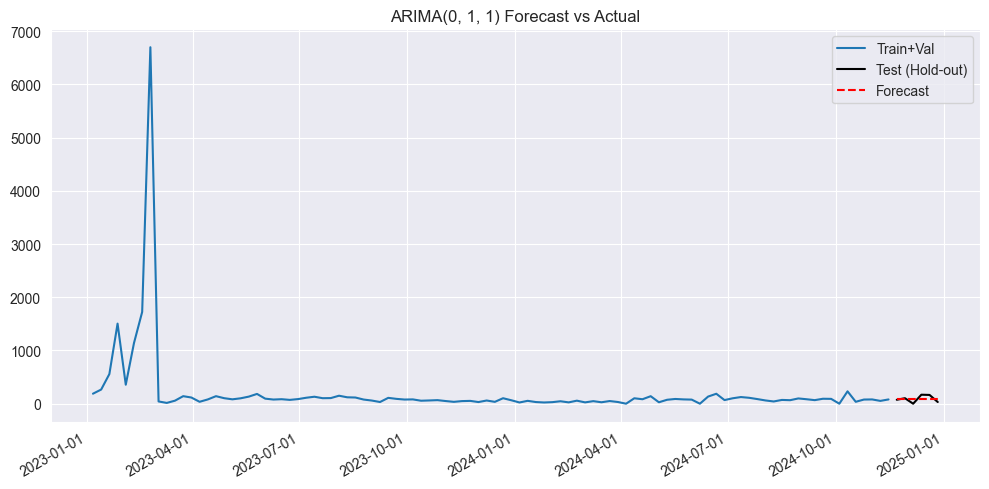

In [35]:
# Получаем даты как отдельный столбец
dates_train_val = df_one.loc[train.index.union(val.index), 'Week_End_Date']
dates_test = df_one.loc[test.index, 'Week_End_Date']

# Объединяем данные
train_val_full = pd.concat([train, val])

# Обучение модели
model = ARIMA(train_val_full.values, order=best_cfg)
model_fit = model.fit()

# Прогноз на тест
forecast = model_fit.forecast(steps=len(test))

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(dates_train_val, train_val_full.values, label='Train+Val')
plt.plot(dates_test, test.values, label='Test (Hold-out)', color='black')
plt.plot(dates_test, forecast, label='Forecast', color='red', linestyle='--')

# Форматирование оси X с датами
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Оформление
plt.title(f"ARIMA{best_cfg} Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# MAE
mae_test = mean_absolute_error(test, forecast)

# WAPE
wape_test = np.sum(np.abs(test - forecast)) / np.sum(np.abs(test)) * 100

print(f"MAE на hold-out: {mae_test:.2f}")
print(f"WAPE на hold-out: {wape_test:.2f}%")

MAE на hold-out: 55.30
WAPE на hold-out: 61.08%


Для всего датасета

In [5]:
# Список уникальных рядов
row_ids = df['row_id'].unique()

# Группируем по рядам: создаём словарь row_id → DataFrame
series_dict = {
    row_id: group.sort_values('Week_End_Date')[['Week_End_Date', 'fact']].reset_index(drop=True)
    for row_id, group in df.groupby('row_id')
}

print(f"Всего рядов для обработки: {len(series_dict)}")

Всего рядов для обработки: 602


In [6]:
def process_single_series(row_id, df_series, p_values=range(0, 3), d_values=range(0, 3), q_values=range(0, 3)):
    warnings.filterwarnings("ignore")

    # Проверка на длину
    if len(df_series) < 20:
        return {'row_id': row_id, 'status': 'too_short'}

    # Сортировка
    df_series = df_series.sort_values('Week_End_Date')
    y = df_series['fact'].values
    dates = df_series['Week_End_Date'].values

    # Деление на train, val, test
    n_total = len(y)
    n_train = int(n_total * 0.90)
    n_val = int(n_total * 0.05)
    n_test = n_total - n_train - n_val

    train, val, test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]
    test_dates = dates[n_train+n_val:]

    # Grid Search
    best_score, best_cfg = float('inf'), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p,d,q))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(val))
            mae = mean_absolute_error(val, forecast)
            if mae < best_score:
                best_score, best_cfg = mae, (p,d,q)
        except:
            continue

    if best_cfg is None:
        return {'row_id': row_id, 'status': 'model_fail'}

    # Финальная модель
    train_val = np.concatenate([train, val])
    try:
        model = ARIMA(train_val, order=best_cfg)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=n_test)
        forecast = np.maximum(forecast, 0)  # Ограничение снизу

        # Метрики
        mae = mean_absolute_error(test, forecast)
        wape = np.sum(np.abs(test - forecast)) / np.sum(np.abs(test)) * 100
        # SMAPE
        denominator = (np.abs(test) + np.abs(forecast)) / 2
        smape = np.mean(np.where(denominator == 0, 0, np.abs(test - forecast) / denominator)) * 100

        return {
            'row_id': row_id,
            'status': 'ok',
            'best_order': best_cfg,
            'mae': mae,
            'wape': wape,
            'smape': smape,
            'test_dates': test_dates,
            'forecast': forecast.tolist(),
            'actual': test.tolist()
        }
    except:
        return {'row_id': row_id, 'status': 'fit_fail'}

In [7]:
# Обёртка с tqdm для прогресс-бара
results = Parallel(n_jobs=-1)(
    delayed(process_single_series)(row_id, series_dict[row_id])
    for row_id in tqdm.tqdm(row_ids)
)

# Отфильтровать успешные результаты
results_ok = [r for r in results if r['status'] == 'ok']

# Преобразовать в DataFrame (без прогнозов)
summary = pd.DataFrame([{
    'row_id': r['row_id'],
    'p': r['best_order'][0],
    'd': r['best_order'][1],
    'q': r['best_order'][2],
    'MAE': r['mae'],
    'WAPE': r['wape'],
    'SMAPE': r['smape']
} for r in results_ok])

print(f"Успешно обработано: {len(results_ok)} рядов")
summary

100%|██████████| 602/602 [01:08<00:00,  8.73it/s]


Успешно обработано: 602 рядов


,row_id,p,d,q,MAE,WAPE,SMAPE
0,A_a_AC_TP 0.2,1,1,1,1.345510,60.363862,61.794563
1,A_a_AC_TP 1.0,2,2,1,87.358500,100.000000,200.000000
2,A_a_AD_PET 1.0,0,1,1,55.299667,61.083456,76.782227
3,A_b_AA_PET 0.5,1,2,0,61.267008,101.700357,199.892056
4,A_b_AA_PET 1.0,0,1,0,23.247333,113.738218,180.538825
...,...,...,...,...,...,...,...
597,I_am_AH_PET 1.0,1,2,1,179.629831,100.000000,200.000000
598,I_am_AJ_PET 1.0,2,2,1,75.643722,85.732995,137.364708
599,I_an_AC_PET 0.3,0,1,1,6.764905,114.130671,181.939742
600,I_an_AC_TP 2.0,1,2,0,178.945833,100.000000,200.000000


In [9]:
summary['WAPE_clipped'] = summary['WAPE'].clip(upper=300)
summary[['WAPE', 'SMAPE', 'WAPE_clipped']].describe()

,WAPE,SMAPE,WAPE_clipped
count,602.000000,602.000000,602.000000
mean,601.107747,98.833234,99.275019
std,8640.015068,50.150603,61.591119
min,15.803695,14.923122,15.803695
25%,62.085254,61.525557,62.085254
50%,94.548575,88.713575,94.548575
75%,102.720727,133.314847,102.720727
max,199805.013200,200.000000,300.000000


Отбор рядов для графиков

In [11]:
# Новый список
new_selected_rows = [
  'E_u_AD_PET 0.5',
  'I_am_AE_PET 0.45',
  'A_c_AJ_PET 0.5',
  'D_o_AC_TP 0.2',
  'I_am_AA_PET 0.5'
]
print("Новая выборка row_id для визуализаций:", new_selected_rows)

Новая выборка row_id для визуализаций: ['E_u_AD_PET 0.5', 'I_am_AE_PET 0.45', 'A_c_AJ_PET 0.5', 'D_o_AC_TP 0.2', 'I_am_AA_PET 0.5']


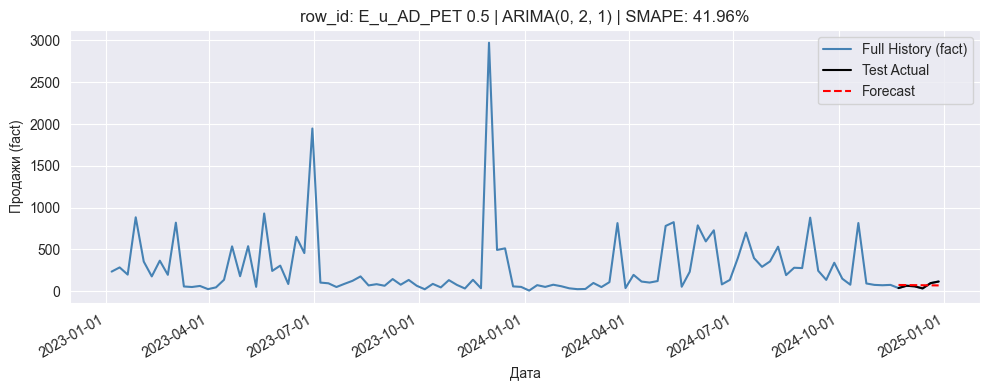

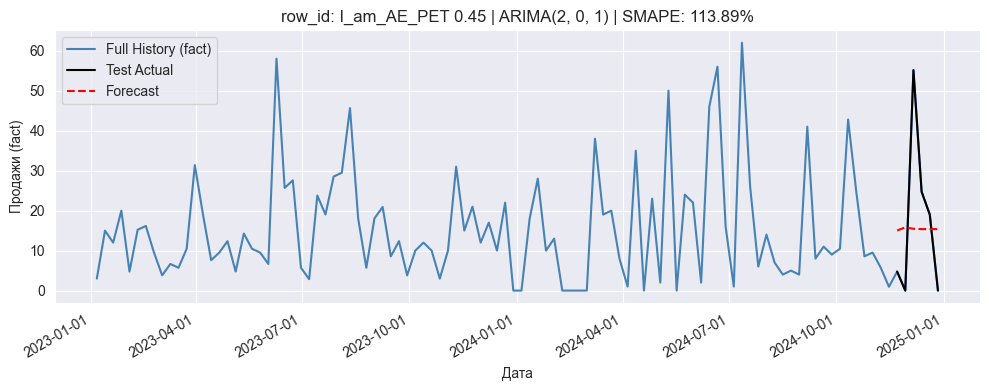

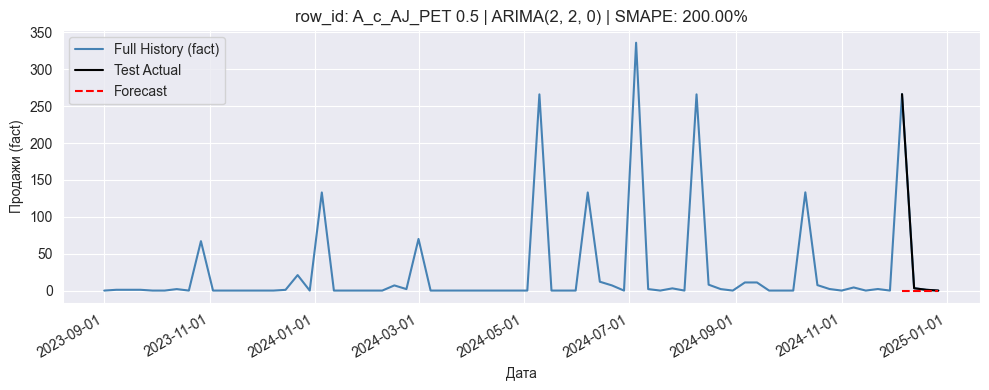

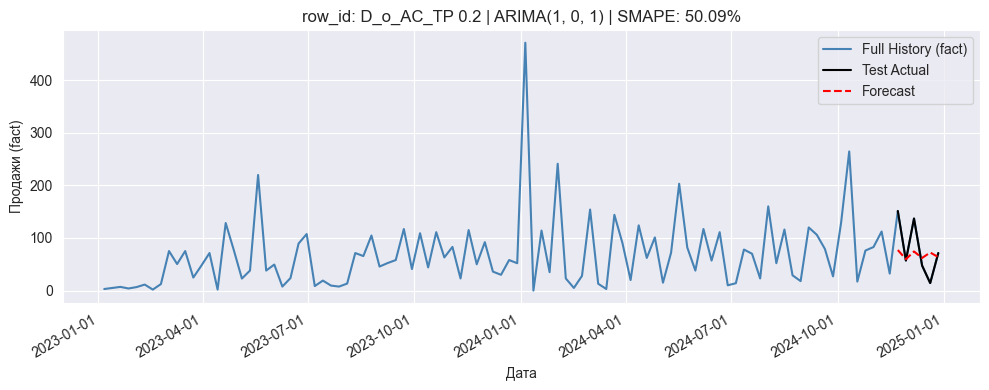

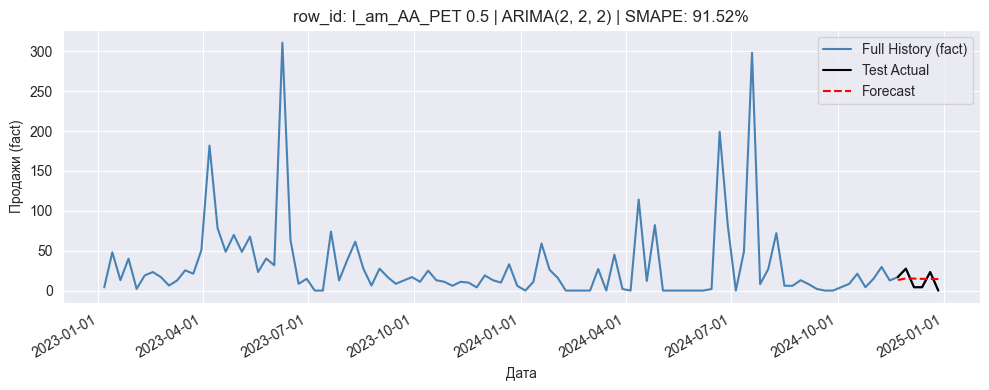

In [12]:
for row_id in new_selected_rows:
    result = next(r for r in results_ok if r['row_id'] == row_id)
    full_df = series_dict[row_id].copy()
    full_df['Week_End_Date'] = pd.to_datetime(full_df['Week_End_Date'])
    
    # Определим границы hold-out (test) по датам
    test_dates = pd.to_datetime(result['test_dates'])
    forecast = result['forecast']
    actual_test = result['actual']

    # Построение графика
    plt.figure(figsize=(10, 4))
    
    # Вся история фактов
    plt.plot(full_df['Week_End_Date'], full_df['fact'], label='Full History (fact)', color='steelblue')

    # Прогноз и актуальные значения (только на тесте)
    plt.plot(test_dates, actual_test, label='Test Actual', color='black')
    plt.plot(test_dates, forecast, label='Forecast', color='red', linestyle='--')

    # Оформление
    plt.title(f"row_id: {row_id} | ARIMA{result['best_order']} | SMAPE: {result['smape']:.2f}%")
    plt.xlabel("Дата")
    plt.ylabel("Продажи (fact)")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
# Фильтруем и собираем метрики
metrics_summary = []

for row_id in new_selected_rows:
    r = next((x for x in results_ok if x['row_id'] == row_id), None)
    if r:
        metrics_summary.append({
            'row_id': row_id,
            'mae': round(r.get('mae', float('nan')), 2),
            'wape': round(r.get('wape', float('nan')), 2),
            'smape': round(r.get('smape', float('nan')), 2),
        })
    else:
        metrics_summary.append({
            'row_id': row_id,
            'mae': 'N/A',
            'wape': 'N/A',
            'smape': 'N/A',
        })

# Создаём DataFrame
metrics_df_subset = pd.DataFrame(metrics_summary)
metrics_df_subset

,row_id,mae,wape,smape
0,E_u_AD_PET 0.5,28.35,41.49,41.96
1,I_am_AE_PET 0.45,15.69,90.77,113.89
2,A_c_AJ_PET 0.5,67.64,100.00,200.00
3,D_o_AC_TP 0.2,36.60,45.90,50.09
4,I_am_AA_PET 0.5,10.04,79.13,91.52
